In [ ]:
%matplotlib inline

from dit.divergences import jensen_shannon_divergence
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from dateutil.parser import parse
import plotly.graph_objs as go
from shapely.geometry import *
from datetime import datetime  
import plotly.plotly as py
import scipy.stats as st
import geopandas as gpd
from scipy import stats
import pandas as pd
import numpy as np  
import operator
import geojson
import math 
import sys 
import dit

import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
 
# path to data
venues = "../../../../raw_data/venues/Singapore_venues.txt"
transitions = "../../../../raw_data/transitions/Singapore_transitions.txt"

# venue ID -> name
venue_id_to_name = {} 
# venue ID -> coordinates for that venue
venue_id_to_coords = {} 
# venue ID -> SPECIFIC category
venue_id_to_category_specific = {} 
# venue ID -> GENERAL category
venue_id_to_category_general = {} 
# venue ID -> opening date
venue_id_to_opening = {}  

### STEP 1: get all venues 
with open(venues, 'r') as f:
    for rows in f:
        rows = rows.split("\t")
        # unique ID 
        ID = rows[0] 
        # name
        name = rows[1]
        venue_id_to_name[ID] = name 
        # coordinates 
        coordinates = (float(rows[2]), float(rows[3]))
        venue_id_to_coords[ID] = coordinates  
        # specific category
        type_venue = rows[7]
        venue_id_to_category_specific[ID] = type_venue  
        # general categorgy
        type_venue = rows[8]
        venue_id_to_category_general[ID] = type_venue  
        
        # date
        date = rows[9].strip()  
        date_cleaned = datetime.strptime(date, '%Y-%m-%d')
        venue_id_to_opening[ID] = date_cleaned
        

LIST_OF_VENUES = venue_id_to_opening.keys()

# venue ID -> list of *FIRST* checkins to that venue       
venue_id_to_times = {} 
with open(transitions, 'r') as f:
    for rows in f:
        rows = rows.split("\t")
        location1 = rows[0]
        time1 = rows[1] 
        if location1 in venue_id_to_coords:
            venue_id_to_times.setdefault(location1, [])
            time_cleaned = datetime.fromtimestamp(int(time1))
            venue_id_to_times[location1].append(time_cleaned)
             
# venue id to the number of checkins to that venue 
venue_id_to_num = {}
for v in LIST_OF_VENUES:
    if v not in venue_id_to_times:
        continue 
    venue_id_to_num[v] = len(venue_id_to_times[v])    
    
 

In [ ]:
places_opened_to_num = {}
for v in venue_id_to_opening: 
    if v not in venue_id_to_num: 
        continue 
    date = venue_id_to_opening[v]
    year = date.year
    month = date.month 
    places_opened_to_num[v] = venue_id_to_num[v]
         
# list of new venues that have at least 100 checkins 
venues_above_threshold = [venue for venue in places_opened_to_num if places_opened_to_num[venue] > 100]
print len(venues_above_threshold)

In [ ]:
# check if there's data last 6 months
# is there less than 12 checkins after july 2013
venues_closed = set()
# whether venue is open or closed 
venue_to_status = {}
for v in venues_above_threshold:
    if v not in venue_id_to_times: 
        continue
    times = venue_id_to_times[v]
    checkins_after = 0
    for date in times:
        year = date.year
        month = date.month
        if year == 2013 and month > 6 or year > 2014:
            checkins_after += 1 
    if checkins_after <= 6: # less than one checkin a month
        venues_closed.add(v)     
        venue_to_status[v] = 0
    else: 
        venue_to_status[v] = 1 

In [5]:
num_closed = 0

date_comparison = datetime.strptime('Jul2013', '%b%Y')
max_possible = datetime.strptime('Jun2011', '%b%Y')   
max_possible = date_comparison - max_possible
arr_days_open = []

for v in venues_above_threshold:  
    num_closed += 1 
    delta = date_comparison - venue_id_to_opening[v]
    arr_days_open.append(delta.days) 
    
print max_possible
print len(arr_days_open)

761 days, 0:00:00
15171


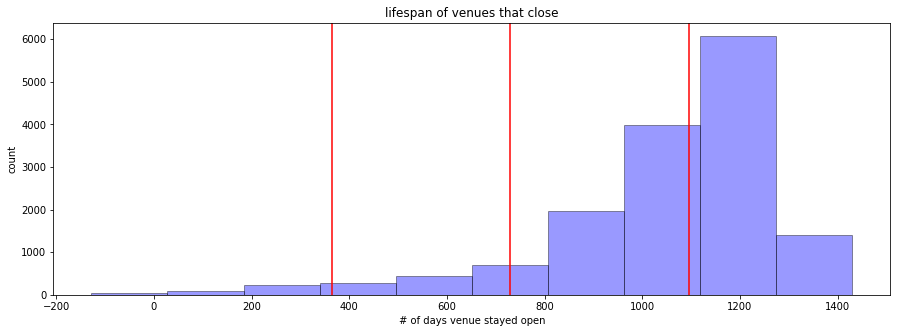

In [178]:
plt.figure(figsize=(15, 5))
array_bins, bins, patches = plt.hist(arr_days_open, 10, facecolor='blue', alpha=0.4, edgecolor="k")
plt.axvline(x=365, c='r')
plt.axvline(x=365*2, c='r')
plt.axvline(x=365*3, c='r')

plt.xlabel('# of days venue stayed open')
plt.ylabel('count')
plt.title("lifespan of venues that close")

In [13]:
from haversine import haversine
# when people end up at this ward, from where do they come?
# that same ward or a different ward?
ward_to_num_inflow_transitions = {}
# when people leave this ward, where do they go? 
# that same ward or a different ward?
ward_to_num_outflow_transitions = {} 
# within 
ward_to_num_within_transitions = {}

# speed and distance 
ward_to_speed_entering = {} 
ward_to_distance_entering = {}
ward_to_speed_leaving = {}
ward_to_distance_leaving = {}

error_counter = 0

with open(transitions, 'r') as f:
    for rows in f:
        rows = rows.split("\t")
        location_1 = rows[0]
        time1 = rows[1]
        location_2 = rows[2]
        time2 = rows[3]
        
        if location_1 not in venue_id_to_ward or location_2 not in venue_id_to_ward: 
            error_counter += 1
            continue
        ward_1 = venue_id_to_ward[location_1]
        ward_2 = venue_id_to_ward[location_2]
        if ward_1 == ward_2:
            ward_to_num_within_transitions.setdefault(ward_2, 0)
            ward_to_num_within_transitions[ward_2] += 1
        else:  
            ward_to_num_inflow_transitions.setdefault(ward_2, 0)
            ward_to_num_inflow_transitions[ward_2] += 1 
            
            ward_to_num_outflow_transitions.setdefault(ward_1, 0)
            ward_to_num_outflow_transitions[ward_1] += 1
            
            coords_1 = venue_id_to_coords[location_1]
            coords_2 = venue_id_to_coords[location_2]
            
            distance_current = haversine(coords_1, coords_2)
            ward_to_distance_entering.setdefault(ward_2, [])
            ward_to_distance_entering[ward_2].append(distance_current)
            ward_to_distance_leaving.setdefault(ward_1, [])
            ward_to_distance_leaving[ward_1].append(distance_current)

            # km/hrs
            timeTravelled = int(time2) - int(time1)
            timeTravelled = (timeTravelled / 60.0)/ 60.0
            if timeTravelled > 0:
                speed_current = distance_current / timeTravelled
            else: 
                speed_current = 0
            ward_to_speed_entering.setdefault(ward_2, [])
            ward_to_speed_entering[ward_2].append(speed_current) 
            
            ward_to_speed_leaving.setdefault(ward_1, [])
            ward_to_speed_leaving[ward_1].append(speed_current)
            
            

In [59]:
# calculate entropy
ward_to_entropy = {}
for current_w in ward_to_set_venues: 
    
    dict_cat_to_count = {}
    list_venues = ward_to_set_venues[current_w]
    for current_v in list_venues: 
        categ = venue_id_to_category_general[current_v]
        dict_cat_to_count.setdefault(categ, 0)
        dict_cat_to_count[categ] += 1
        
    sum_values = sum(dict_cat_to_count.values())
    perc_dict = {}
    for raw_vals in dict_cat_to_count: 
        perc_dict[raw_vals] = dict_cat_to_count[raw_vals] / float(sum_values)
    
    sum_vals = 0
    for k, perc in perc_dict.items():  
        sum_vals += perc * math.log(perc) 
    sum_vals *= -1
    
    entropy = sum_vals / len(perc_dict)
    ward_to_entropy[current_w] = entropy 

In [182]:
print "GOAL: ", len(venues_above_threshold)
i = 0
venue_to_set = {}
for v in venues_above_threshold: 
    i += 1
    venue_to_set.setdefault(v, set())
    c1 = venue_id_to_coords[v]
    for v2 in venue_id_to_coords: 
        if v2 == v: 
            continue
        c2 = venue_id_to_coords[v2]
        distance = haversine(c1, c2)
        if distance < 5:  
            venue_to_set[v].add(v2) 
    if i % 500 == 0: 
        print i

GOAL:  15171
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100


In [187]:
outer = []
for v in venue_to_set: 
    inner = []
    inner.append(v) 
    set_vals = venue_to_set[v]
    for inner_v in set_vals: 
        inner.append(inner_v)
    outer.append(inner)

In [188]:
import json
  
with open('nearby_venues.txt', 'w') as f:
    json.dump(outer, f)

In [189]:
with open('nearby_venues.txt') as f:
    a = json.load(f)

In [190]:
print len(a)

15171


In [94]:
all_general = list(set(venue_id_to_category_general.values()))
all_specific = list(set(venue_id_to_category_specific.values()))

myData = np.array([["venue", "ward", "within", "in", "out", "ratio in", "ratio out", \
                    "ratio in/out", "distance","speed","dis_std", "spe_std", "dis_lv", \
                    "spe_lv", "dis_lv_std", "spe_lv_std", "spec", "gen", "entropy","closed or open"]])
NUM_FEATURES = 19
count = 0
for new_venue in venues_above_threshold: 
    # travel out of city bounds 
    if new_venue not in venue_id_to_ward:  
        continue 
    inner = np.array([])
    new_ward = venue_id_to_ward[new_venue] 
    if new_ward not in ward_to_num_within_transitions or new_ward not in ward_to_num_inflow_transitions:  
        print new_ward
        continue
    if new_ward not in ward_to_num_outflow_transitions or new_venue not in venue_to_status: 
        continue 
    if new_venue not in venue_id_to_category_specific or new_venue not in venue_id_to_category_general: 
        continue
    if new_ward not in ward_to_distance_entering or new_ward not in ward_to_speed_entering:
        print new_venue
        continue
         
    within = ward_to_num_within_transitions[new_ward]
    inflow = ward_to_num_inflow_transitions[new_ward]
    outflow = ward_to_num_outflow_transitions[new_ward]
    status = venue_to_status[new_venue]
    spec = venue_id_to_category_specific[new_venue]
    gen = venue_id_to_category_general[new_venue]
    
    dis_avg = np.mean(ward_to_distance_entering[new_ward])
    speed_avg = np.mean(ward_to_speed_entering[new_ward])
    dis_std = np.std(ward_to_distance_entering[new_ward])
    speed_std = np.std(ward_to_speed_entering[new_ward])
    
    dis_avg_lea = np.mean(ward_to_distance_leaving[new_ward])
    speed_avg_lea = np.mean(ward_to_speed_leaving[new_ward])
    dis_std_lea = np.std(ward_to_distance_leaving[new_ward])
    speed_std_lea = np.std(ward_to_speed_leaving[new_ward])
    
    entropy = ward_to_entropy[new_ward]
    
    index_spec = all_specific.index(spec)
    index_gen = all_general.index(gen) 
      
    inner = np.append(inner, count)
    inner = np.append(inner, new_ward)
    inner = np.append(inner, within)
    inner = np.append(inner, inflow)
    inner = np.append(inner, outflow)    
    inner = np.append(inner, float(within) / inflow)
    inner = np.append(inner, float(within) / outflow)
    inner = np.append(inner, float(inflow) / outflow)
    inner = np.append(inner, dis_avg)  
    inner = np.append(inner, speed_avg)
    inner = np.append(inner, dis_std)
    inner = np.append(inner, speed_std)
    inner = np.append(inner, dis_avg_lea)
    inner = np.append(inner, speed_avg_lea)
    inner = np.append(inner, dis_std_lea)
    inner = np.append(inner, speed_std_lea)
    
    inner = np.append(inner, entropy)
    
    inner = np.append(inner, index_spec)
    inner = np.append(inner, index_gen)
    
    # output
    inner = np.append(inner, status)  
    myData = np.concatenate([myData, [inner]])   
    count += 1

220
220
202
202
308
25
61


In [95]:
count

14928

In [96]:
import csv
myFile = open('features.csv', 'w')
with myFile:
    writer = csv.writer(myFile)
    writer.writerows(myData)  
print("Writing complete")

Writing complete


In [97]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics


dataframe = pandas.read_csv("features.csv", header=None)
dataset = dataframe.values 

X = dataset[:, 0:NUM_FEATURES]
y = dataset[:, NUM_FEATURES]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics


std_scale = StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

#print the distribution of classes on train/test

print pd.value_counts(pd.Series(y_test), normalize=True)

print pd.value_counts(pd.Series(y_train), normalize=True)


1.0    0.724046
0.0    0.275954
dtype: float64
1.0    0.723999
0.0    0.276001
dtype: float64


In [99]:
y

array([ 1.,  1.,  1., ...,  0.,  1.,  1.])

In [100]:

from sklearn.linear_model import LogisticRegression

#logistic regression
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

predicted = model.predict(X_test)
probs_LR = model.predict_proba(X_test)

print (metrics.accuracy_score(y_test, predicted))
print (metrics.roc_auc_score(y_test, probs_LR[:, 1]))

print (metrics.confusion_matrix(y_test, predicted))
print (metrics.classification_report(y_test, predicted))

#logistic regression coefficients
# print pd.DataFrame(X.columns) # NEED TO ADD LABEL TO COLUMNS
print pd.DataFrame(np.transpose(model.coef_)) 

0.563965170797
0.566247990444
[[ 422  402]
 [ 900 1262]]
             precision    recall  f1-score   support

        0.0       0.32      0.51      0.39       824
        1.0       0.76      0.58      0.66      2162

avg / total       0.64      0.56      0.59      2986

           0
0  -0.008381
1  -0.191882
2  -0.083083
3   0.139608
4  -0.061889
5   0.322152
6  -0.254702
7   0.064089
8   0.170968
9  -0.014757
10  0.051564
11  0.079443
12  0.074045
13 -0.025985
14 -0.231204
15 -0.036415
16 -0.014137
17 -0.154038
18 -0.058313


In [101]:

#gradient boosting 
from sklearn import ensemble
clf = ensemble.GradientBoostingClassifier()
clf.fit(X_train, y_train)

predicted = clf.predict(X_test)
probs_GB = clf.predict_proba(X_test)

print (metrics.accuracy_score(y_test, predicted))
print (metrics.roc_auc_score(y_test, probs_GB[:, 1]))

print (metrics.confusion_matrix(y_test, predicted))
print (metrics.classification_report(y_test, predicted))

#random baseline
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy='uniform')
clf.fit(X_train, y_train)

predicted = clf.predict(X_test)
probs = clf.predict_proba(X_test)

print (metrics.accuracy_score(y_test, predicted))
print (metrics.roc_auc_score(y_test, probs[:, 1]))

print (metrics.confusion_matrix(y_test, predicted))
print (metrics.classification_report(y_test, predicted)) 

0.725720026792
0.621877048849
[[  23  801]
 [  18 2144]]
             precision    recall  f1-score   support

        0.0       0.56      0.03      0.05       824
        1.0       0.73      0.99      0.84      2162

avg / total       0.68      0.73      0.62      2986

0.506697923644
0.5
[[ 430  394]
 [1079 1083]]
             precision    recall  f1-score   support

        0.0       0.28      0.52      0.37       824
        1.0       0.73      0.50      0.60      2162

avg / total       0.61      0.51      0.53      2986



In [80]:
def create_baseline(): 
    model = Sequential()
    model.add(Dense(1, input_dim=NUM_FEATURES, kernel_initializer='normal', activation='relu')) # intially 60
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid')) 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
    return model  

estimator = KerasClassifier(build_fn=create_baseline, nb_epoch=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100)) 

Results: 71.76% (1.91%)


In [102]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=1)
clf.fit(X_train, y_train)

predicted = clf.predict(X_test)
probs_NN = clf.predict_proba(X_test)

print (metrics.accuracy_score(y_test, predicted))
print (metrics.roc_auc_score(y_test, probs_NN[:, 1]))

print (metrics.confusion_matrix(y_test, predicted))
print (metrics.classification_report(y_test, predicted))


0.719691895512
0.560478094716
[[  44  780]
 [  57 2105]]
             precision    recall  f1-score   support

        0.0       0.44      0.05      0.10       824
        1.0       0.73      0.97      0.83      2162

avg / total       0.65      0.72      0.63      2986



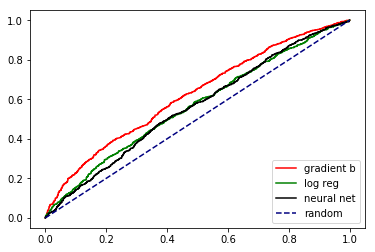

In [103]:
#plot area under curve in order to compare multiple classifiers
fpr, tpr, _ = metrics.roc_curve(y_test, probs_GB[:, 1]) #classifier 1
fpr2, tpr2, _ = metrics.roc_curve(y_test, probs_LR[:, 1]) #classifier 2
fpr3, tpr3, _ = metrics.roc_curve(y_test, probs_NN[:, 1]) #classifier 3

plt.plot(fpr,tpr, color='red', label='gradient b') 
plt.plot(fpr2,tpr2, color='green', label='log reg')
plt.plot(fpr3,tpr3, color='black', label='neural net')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='random')
plt.legend(loc="lower right") 